# EDSA Movie Recommendation Challenge

# Introduction

## Context

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

## Problem Statement
With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

## Evaluation
The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error (RMSE) is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process.

# Data Exploration

## Installing and Importing packages


In [2]:
# !pip install turicreate

In [3]:
import pandas as pd
import numpy as np
import re

# import turicreate

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Overview
This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

### Source
The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB

### Supplied Files

1. genome_scores.csv - a score mapping the strength between movies and tag-related properties.
2. genome_tags.csv - user assigned tags for genome-related scores
3. imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
4. movies.csv - consists of userId,movieId,tag and timestamp
5. links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
6. tags.csv - User assigned for the movies within the dataset.
7. test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
8. train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

### Loading data files

In [5]:
train_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/train.csv', usecols = ['userId', 'movieId', 'rating'])
test_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/test.csv')
imdb_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/imdb_data.csv')
movies_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/movies.csv')

In [6]:
print(train_data.shape)
train_data.head()

(10000038, 3)


,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


Train data consists of 3 columns (userId, movieId and rating). We dropped the timestamp when we loaded the data. We have 10 million rows in total.

In [7]:
print(imdb_data.shape)
imdb_data.head(3)

(27278, 6)


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry


Imdb_data has 5 columns besides the movieId, i.e title_cast, movie director, plot key words, runtime and budget. Has 27278 movieIds, much less than we have in the training data.

In [8]:
print(movies_data.shape)
movies_data.head(3)

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Movies_data contains a movie's actual title as well as the movie genre. 62423 movies in total indicating that some of the movies in the table are not in train_data.

###### task: merge tables
Below we utilise a pandas function that joins 2 data tables thus the function takes as argument 2 dataframes, joins them by a column. Note that the joining operation can be done on columns such as userId or movieId. First we'll merge imdb_data and movies_data as these tables contain information thats directly related to each other by movieId. We call the new table items_data, referencing movies as items. Note also that we do an outer join. This is so we can preserve all movieIds. Later we'll drop movieIds that are not available in the training data. The resulting table will have 64835 movies in total and 6 columns as displayed below.

In [9]:
items_data = pd.merge(
    left = imdb_data,
    right = movies_data,
    on = ['movieId'],
    how = 'outer'
)

print(items_data.shape)
items_data.head(3)

(64835, 8)


,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,Jumanji (1995),Adventure|Children|Fantasy
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,Grumpier Old Men (1995),Comedy|Romance


The next step is to drop movie items in items_data that are not available in train_data. To determine if a movie item is present in train_data, we'll do yet another merge operation. This time we merge the table items_data with only the movieId column of train_data. This we do for computational and storage reasons as the merge will result in many duplicate rows for each userId in train_data. We'll also set the how parameter of the merge function to left to prioritise observation in train_data and drop those that are not. Further, instead of immediately storing the merged table, we'll first drop duplicates in it so that we dont have duplicated information about movie items. 

In [10]:
items_data = pd.merge(left = train_data[['movieId']], right = items_data, ).drop_duplicates()
print(items_data.shape)
items_data.head(3)

(48213, 8)


,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,57669,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
4253,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy
8901,5459,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi


The result is items_data with only 48213 rows and 8 columns. Does train_data have 48213 movieIds? Lets check.

In [11]:
train_data['movieId'].nunique()

48213

###### task: investigate missing entries

In [12]:
train_data.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

train_data has zero missing entires.

In [13]:
items_data.isna().sum() / items_data.shape[0]

movieId          0.000000
title_cast       0.697799
director         0.695435
runtime          0.729865
budget           0.852094
plot_keywords    0.711572
title            0.000000
genres           0.000000
dtype: float64

items_data has a significant amount of missing entries, between 69% and 85% across the columns. Mostly missing are the movie budgets. This indicates that we ought to be careful interms of the conclusions we draw from this movie contents table. To be able to analyse the textual data in these columns however, we need to treat them. Similarly, for the budget and runtime columns. How do we treat them? ...

In [14]:
# items_data.fillna(' ', inplace = True)

###### task: cleaning up the text data
In this task we take the opportunity to do further cleaning of the text content of movie items. How do we clean the text? ...

In [15]:
items_data.head(3)

,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,57669,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
4253,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy
8901,5459,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi


In [16]:
# text_corpus = [row[2].replace(' ', '_').replace('|', ' ') + ' ' + row[3].replace('|', ' ') + ' ' + row[4].replace(' ', '_').replace('|', ' ') + ' ' + row[6].replace(' ', '_').replace('|', ' ') for row in item_data.itertuples()]

In [17]:
# item_data['text'] = pd.Series(text_corpus)

# del text_corpus, imdb_data, movies_data
# item_data.drop(['title_cast', 'director', 'plot_keywords', 'title', 'genres'], axis = 1, inplace = True)

# item_data.head(3)

In [18]:
# def cleanText(text):
#     new_text = text.replace('_', '')
#     return new_text

# item_data['text'] = item_data['text'].map(cleanText)

# item_data.head(3)

# Exploratory Data Analysis
As we have noticed, we have a significant number of users and movies in the data set, 48213 and 162541 respectively. This results in a little over 10 million rows of training data if the data is in tidy format i.e each row represents a user-movie combination. However, to analyse the data through use of machine learning techniques we will have to spread the dataset such that each row represents a single user and each column a single movie item or vise versa. Note that in this format the cells should contain ratings. This will then result in a highly sparse matrix as users generally do not provide a rating for a movie they have not watched. This will be a very large matrix and hard to process with small RAM computers.

These concerns motivate most of what we cover in this section. The first part of EDA will be devoted to:
- understanding the basic structured of the ratings. we ask questions such as: which are the most rated/watched movies, which users tend to watch a lot or the least number of movies and what ratings do the provide?
- understand the additional movie specific information such as the cast, directors etc. We'll make an attempt to identify movie items that can be grouped together and analyse the ratings per group.

Lets start with the ratings. We start of by visualising a distribution of the ratings as they appear in the entire training data. The ratings are on a scale of 0.5 to 5. The figure below shows that the most common rating is 4. The least common is 0.5. It seems like high ratings are common indicating that perhaps users generally tend to like the movies they watch. If there is a current recommendation system, it's already doing a satisfactory job.

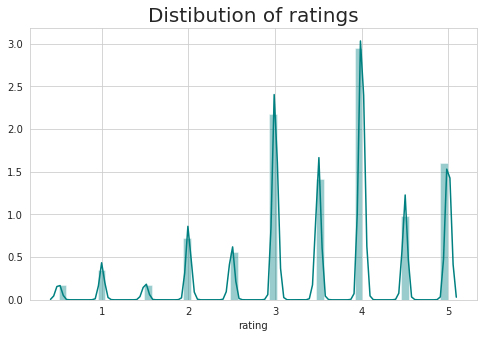

In [21]:
plt.figure(figsize = (8, 5))
g = sns.distplot(train_data['rating'], color = 'teal')
g.set_title('Distibution of ratings', fontsize = 20)
plt.show()

Now. Are there users who watch a lot more movies than others. Look at the output below. Looks like user with ID 72315 has watched and rated nearly 13000 movies of the approx 48000 available in the data. Thats significant, especially considering he/she is seconded by a user wiyh 3680 in their list. Out of curiosity lets just take a look at what our top user rates his/her movies.

In [22]:
num_of_movies_watched = train_data.groupby('userId')['movieId'].count().sort_values(ascending = False)
num_of_movies_watched

userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
          ...  
55362         1
121071        1
127098        1
53640         1
105714        1
Name: movieId, Length: 162541, dtype: int64

From the figure below the top user's most common rating is 3. EWe'll just assume that any rating above 3 means he likes the movie and any below 3 he dislikes the movie. I think we can conclude that he likes more movies than he dislikes. Note that although we have extreme users like our top user, there are users who've watched as few movies as 1 in the dataset. Let's just be aware of this as we move on.

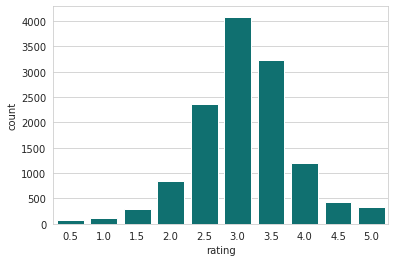

In [185]:
top_user = num_of_movies_watched.index.tolist()[0]
top_user
top_user_ratings = train_data[train_data['userId'] == top_user]['rating']
top_user_ratings
sns.countplot(top_user_ratings, color = 'teal')

Similar to what we did above, are there movies that tend to be watched and rated by most users. Seeing the output below. There are movies that have been watched by more than 30000 users in the dataset. Thats approximately 21% of all the users. These are very popular movies. Out of curiosity we'll take the top 10 most popular movies and visualise their average rating.

In [186]:
num_of_users_per_movie = train_data.groupby('movieId')['userId'].count().sort_values(ascending = False)
num_of_users_per_movie

movieId
318       32831
356       32383
296       31697
593       29444
2571      29014
          ...  
152731        1
152733        1
152737        1
152743        1
209171        1
Name: userId, Length: 48213, dtype: int64

Looking at the figure below, the most common rating for this group of movies is 3. Also, the movies tend to be liked more than they are disliked, which makes sense given how popular they are.

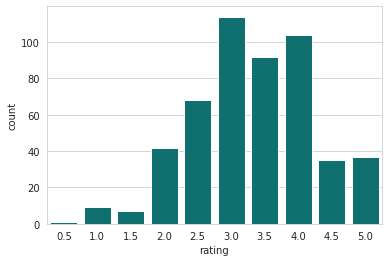

In [188]:
ten_most_popular_movies = num_of_users_per_movie[:10].index.tolist()
data = train_data[train_data['userId'].isin(ten_most_popular_movies)]
sns.countplot(data['rating'], color = 'teal')

Looks like we're approaching a conclusion that most of the ratings tend to be concentrated around either a certain group of users i.e the top users or a certain group of movies i.e most popular movies. Let's ask a more direct question. What is the proportion of ratings accounted for by top users? Similarly, what proportion of the ratings is accounted for by the most popular movies? See the figure below. On the x axis we have the number of users (left) and the number of movies (right) and on the y axis we have the proportion of ratings corresponding to the number of either users and/or movies on the x axis. For example, see that if we take the most common 60000 users we already have 80% of the ratings in the database. This is even more acute for the movies i.e 10000 movies hold nearly 100% of the rating in the database. Most users do watch a lot of movies and most movies are not watched by a lot of users.

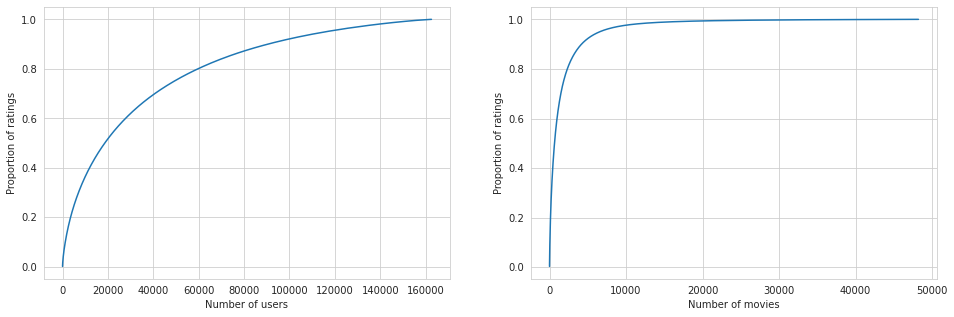

In [190]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
g = num_of_movies_watched.cumsum().div(len(train_data)).reset_index()['movieId'].plot(ax = axes[0])
# g.set_title()
g.set_xlabel('Number of users')
g.set_ylabel('Proportion of ratings')

g = num_of_users_per_movie.cumsum().div(len(train_data)).reset_index()['userId'].plot(ax = axes[1])
# g.set_title()
g.set_xlabel('Number of movies')
g.set_ylabel('Proportion of ratings')
plt.show()

Further, we find that only about 6% (9677 users) of the users have watched more than 200 movies in the database and that only 0.38% have watched less than 5 movies suggesting that users generally watch between 5 and 200 movies(84% of users).

In [193]:
more_than_200 = num_of_movies_watched > 200
userids_w_more_than_200 = num_of_movies_watched[more_than_200].index
print(f"Only {len(userids_w_more_than_200)} users have watched more than 200 movies in the dataset.")

Only 9677 users have watched more than 200 movies in the dataset.


In [194]:
less_than_5 = num_of_movies_watched < 5
userids_w_less_than_5 = num_of_movies_watched[less_than_5].index
print(f"{len(userids_w_less_than_5)} users have watched less than 5 movies in the dataset.")

618 users have watched less than 5 movies in the dataset.


Below we show a visual of the number of movies watched by users excluding the users with more than 200 movies in their watched list. See that the most viewership count is between 5 and 25 where we have more than 60000 users. This number ofcoarse declines as we move along the x axis.

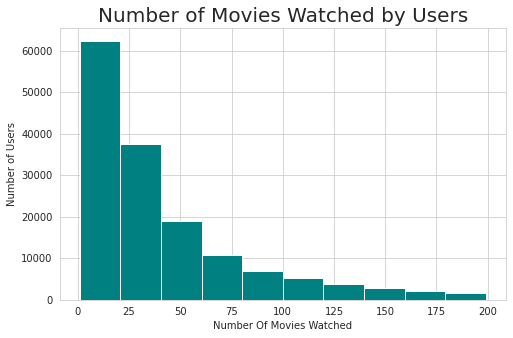

In [25]:
fig = plt.figure(figsize = (8, 5))
less_than_200 = num_of_movies_watched < 200
g = num_of_movies_watched[less_than_200].plot(kind = 'hist', color = 'teal')
g.set_xlabel('Number Of Movies Watched')
g.set_ylabel('Number of Users')
g.set_title('Number of Movies Watched by Users', fontsize = 20)
plt.show()

In [27]:
avg_rating = train_data.groupby('userId')[['rating']].mean().rename(columns = {'rating':'user_avg_rating'})
user_movie_count = pd.DataFrame(num_of_movies_watched).rename(columns = {'movieId':'user_movie_count'})
users_data = pd.concat([avg_rating, user_movie_count], axis = 1).reset_index()

users_data.head()

,userId,user_avg_rating,user_movie_count
0,1,3.910714,28
1,2,3.416667,72
2,3,3.691235,251
3,4,3.308989,89
4,5,3.885714,35


<Figure size 576x360 with 0 Axes>

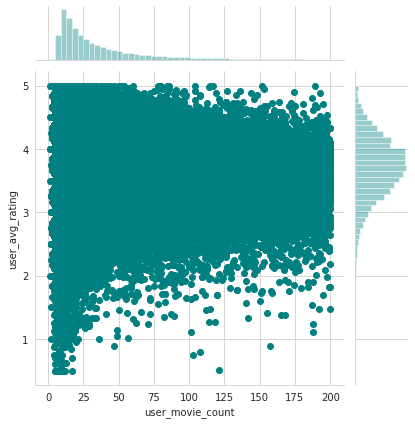

In [34]:
mask = users_data['userId'].isin(userids_w_more_than_200)

fig = plt.figure(figsize = (8, 5))
sns.jointplot(data = users_data[~mask], x = 'user_movie_count', y = 'user_avg_rating', color = 'teal')
plt.show()

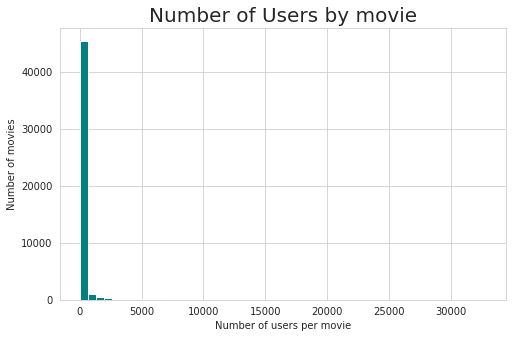

In [78]:
fig = plt.figure(figsize = (8, 5))
g = num_of_users_per_movie.plot(kind = 'hist', bins = 50, color = 'teal')
g.set_ylabel('Number of movies')
g.set_xlabel('Number of users per movie')
g.set_title('Number of Users by movie', fontsize = 20)
plt.show()

In [82]:
movieids_w_less_than_n = num_of_users_per_movie[num_of_users_per_movie < 5].index
print(f"{len(movieids_w_less_than_n)} movies have been watched by less than 5 users in the dataset.")

25231 movies have been watched by less than 5 users in the dataset.


In [91]:
n = 2000
movieids_w_more_than_n = num_of_users_per_movie[num_of_users_per_movie > n].index
print(f" Only {len(movieids_w_more_than_n)} movies have been watched by more than {n} users in the dataset.")

 Only 1223 movies have been watched by more than 2000 users in the dataset.
